In [1]:
import time

import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline

from cataclop.ml.pipeline import factories

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [3]:
MAX_HISTORY = 6
NAN_FLAG = 10000.

In [4]:
d = factories.Dataset.factory('default')
d.load(force=True)

In [5]:
pd.concat([pd.DataFrame(d.players.describe()).T, d.players.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,138408.0,5.023770e+00,2.013027e+00,1.0,3.00,5.0,6.0,1.600000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,138408.0,1.233263e+01,3.128411e+00,3.0,10.00,12.0,15.0,2.400000e+01,int64
distance,138408.0,1.928350e+03,4.998067e+02,800.0,1600.00,2000.0,2300.0,6.856000e+03,int64
earnings,138408.0,5.909599e+06,1.784700e+07,0.0,490000.00,2027500.0,6045000.0,1.471275e+09,int64


In [6]:
df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight',
                'final_odds_ref'
               ] + ['hist_{}_pos'.format(i+1) for i in range(MAX_HISTORY)]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='left', on='race_id')

for f in agg_features:
    df['{}_r'.format(f)] = (df[f] - df['{}_mean'.format(f)]) / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features if f != 'final_odds_ref'] + ['{}_std'.format(f) for f in agg_features] + ['{}_mean'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(NAN_FLAG)


In [7]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

start = time.time()

odds = np.ones([len(df), 20]) * NAN_FLAG
idx = []

races = df.groupby('race_id')

j = 0
for (id, race) in races:
    jj = len(race.index)
    odds_sorted = np.array(sorted(race[race['final_odds_ref']>1.]['final_odds_ref'].values))
    
    
    
    odds[j:j+jj, 0:len(odds_sorted)] = odds_sorted[:20]
    
    idx = idx + list(race.index)
    
    j = j + jj
    
#scaler = StandardScaler()
#odds = scaler.fit_transform(odds)
    
odds_df = pd.DataFrame(odds, columns=['odds_{:d}'.format(i) for i in range(20)], index=idx)
df = pd.concat([df,odds_df], axis=1)

end = time.time()
print(end - start)

38.26384997367859


In [8]:
print(df['start_at'].min(), df['start_at'].max())

2017-01-01 12:40:00 2018-06-22 21:24:00


In [9]:
df['speed'] = (df['distance'] / df['time']).fillna(NAN_FLAG)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(NAN_FLAG)

df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.groupby('race_id').filter(lambda r: r['final_odds_ref'].min() > 0)
df = df.sort_index()
df_orig = df.copy()

In [10]:
#df_test = df_orig[(df_orig['start_at'] > '2018-06-01') & (df_orig['category']=='PLAT')].copy()
df_test = df_orig[(df_orig['start_at'] > '2018-06-07')].copy()
df = df_orig[(df_orig['start_at'] <= '2018-06-06')].copy()

df_test = df_test.sort_index()
df = df.sort_index()

In [11]:
pd.concat([pd.DataFrame(df.describe()).T, df.dtypes], axis=1, sort=True)

dff = df.reset_index()
pd.concat([pd.DataFrame(dff.describe()).T, dff.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,106780.0,5.036346e+00,2.025373e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00,1.600000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,106780.0,1.243496e+01,3.162771e+00,3.000000e+00,1.000000e+01,1.200000e+01,1.500000e+01,2.400000e+01,int64
distance,106780.0,1.926085e+03,5.155121e+02,8.000000e+02,1.500000e+03,2.000000e+03,2.300000e+03,6.856000e+03,int64
earnings,106780.0,6.188416e+06,1.809054e+07,0.000000e+00,6.241552e+05,2.365000e+06,6.572000e+06,1.389165e+09,int64


In [12]:
def random_race(df, cols=None, n=1):

    if cols is None:
        cols = ['position', 'sub_category', 'num', 'final_odds', 'final_odds_ref_r', 'final_odds_ref', 'hist_1_pos', 'hist_1_pos_r', 'hist_1_pos_mean', 'hist_1_pos_std', 'odds_0', 'odds_1']

    return df.reset_index().set_index(['race_id', 'index']).loc[np.random.permutation(df['race_id'].unique())[0:n]][cols]
    

In [13]:
random_race(df)

position         sub_category  num  final_odds  \
race_id index                                                   
3033    21167      11.0  COURSE_A_CONDITIONS    1        19.7   
        21168       3.0  COURSE_A_CONDITIONS    2        16.0   
        21169       1.0  COURSE_A_CONDITIONS    3         2.4   
        21170       9.0  COURSE_A_CONDITIONS    4         9.6   
        21171       7.0  COURSE_A_CONDITIONS    5        40.7   
        21172       8.0  COURSE_A_CONDITIONS    6        15.1   
        21173       2.0  COURSE_A_CONDITIONS    7         4.4   
        21174       4.0  COURSE_A_CONDITIONS    8        27.2   
        21175       6.0  COURSE_A_CONDITIONS    9         9.4   
        21176       5.0  COURSE_A_CONDITIONS   10        20.6   
        21177      12.0  COURSE_A_CONDITIONS   11        29.1   
        21179      10.0  COURSE_A_CONDITIONS   13        81.2   

               final_odds_ref_r  final_odds_ref  hist_1_pos  hist_1_pos_r  \
race_id index                                                               
3033    21167         -0.002659            16.0         3.0     -0.130693   
        21168         -0.183488            14.3         4.0      0.392080   
        21169         -1.406739             2.8         2.0     -0.653467   
        21170         -0.587693            10.5         2.0     -0.653467   
        21171          0.816388            23.7         6.0      1.437627   
        21172         -0.374953            12.5         5.0      0.914853   
        21173         -1.172726             5.0         4.0      0.392080   
        21174          0.699381            22.6         5.0      0.914853   
        21175         -0.470686            11.6         4.0      0.392080   
        21176         -0.236673            13.8         4.0      0.392080   
        21177          0.614285            21.8         0.0     -1.699013   
        21179          2.305563            37.7         0.0     -1.699013   

               hist_1_pos_mean  hist_1_pos_std  odds_0  odds_1  
race_id index                                                   
3033    21167             3.25        1.912875     2.8     5.0  
        21168             3.25        1.912875     2.8     5.0  
        21169             3.25        1.912875     2.8     5.0  
        21170             3.25        1.912875     2.8     5.0  
        21171             3.25        1.912875     2.8     5.0  
        21172             3.25        1.912875     2.8     5.0  
        21173             3.25        1.912875     2.8     5.0  
        21174             3.25        1.912875     2.8     5.0  
        21175             3.25        1.912875     2.8     5.0  
        21176             3.25        1.912875     2.8     5.0  
        21177             3.25        1.912875     2.8     5.0  
        21179             3.25        1.912875     2.8     5.0

In [14]:
features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(10)]

#features = ['odds_{:d}'.format(i) for i in range(10)]

features

['race_count_r',
 'victory_count_r',
 'placed_2_count_r',
 'placed_3_count_r',
 'victory_earnings_r',
 'prev_year_earnings_r',
 'handicap_distance_r',
 'handicap_weight_r',
 'hist_1_pos_r',
 'hist_2_pos_r',
 'hist_3_pos_r',
 'hist_4_pos_r',
 'hist_5_pos_r',
 'hist_6_pos_r',
 'race_count_std',
 'victory_count_std',
 'placed_2_count_std',
 'placed_3_count_std',
 'victory_earnings_std',
 'prev_year_earnings_std',
 'handicap_distance_std',
 'handicap_weight_std',
 'final_odds_ref_std',
 'hist_1_pos_std',
 'hist_2_pos_std',
 'hist_3_pos_std',
 'hist_4_pos_std',
 'hist_5_pos_std',
 'hist_6_pos_std',
 'race_count_mean',
 'victory_count_mean',
 'placed_2_count_mean',
 'placed_3_count_mean',
 'victory_earnings_mean',
 'prev_year_earnings_mean',
 'handicap_distance_mean',
 'handicap_weight_mean',
 'final_odds_ref_mean',
 'hist_1_pos_mean',
 'hist_2_pos_mean',
 'hist_3_pos_mean',
 'hist_4_pos_mean',
 'hist_5_pos_mean',
 'hist_6_pos_mean',
 'declared_player_count',
 'hist_1_pos',
 'hist_2_pos',
 '

In [15]:
pd.options.display.max_columns = 200

In [16]:
random_race(df, ['final_odds_ref', 'winner_dividend'] + features)

final_odds_ref  winner_dividend  race_count_r  victory_count_r  \
race_id index                                                                   
1200    8393              5.3            460.0     -0.794790        -0.768706   
        8394             27.4              0.0      0.905177        -0.118262   
        8396             60.8              0.0      1.876587         0.532181   
        8397              4.4              0.0     -0.734077        -0.118262   
        8398              6.7              0.0     -0.430511         0.532181   
        8400              4.5              0.0     -0.673363        -0.768706   
        8401             34.8              0.0     -0.248372         0.532181   
        8402             67.3              0.0      1.694447         2.483512   
        8403              8.4              0.0     -0.369798        -0.768706   
        8404             36.5              0.0     -0.491224        -0.768706   
        8405              6.5              0.0     -0.734077        -0.768706   

               placed_2_count_r  placed_3_count_r  victory_earnings_r  \
race_id index                                                           
1200    8393           0.066111          0.040291           -0.110485   
        8394           0.793329          0.040291           -0.452456   
        8396           2.247765          2.256304            2.263992   
        8397          -0.661107         -0.846114           -0.368141   
        8398           0.066111         -0.402911           -0.263116   
        8400           0.793329         -0.846114           -0.020838   
        8401          -0.661107          0.040291            1.141477   
        8402           0.066111          1.369899            0.652671   
        8403          -1.388325          0.040291           -0.809883   
        8404          -0.661107         -0.846114           -1.030136   
        8405          -0.661107         -0.846114           -1.003087   

               prev_year_earnings_r  handicap_distance_r  handicap_weight_r  \
race_id index                                                                 
1200    8393               1.060269              10000.0            10000.0   
        8394               0.239759              10000.0            10000.0   
        8396               0.274924              10000.0            10000.0   
        8397              -1.049613              10000.0            10000.0   
        8398               1.177485              10000.0            10000.0   
        8400              -0.862068              10000.0            10000.0   
        8401               1.763564              10000.0            10000.0   
        8402              -0.065001              10000.0            10000.0   
        8403              -0.440092              10000.0            10000.0   
        8404              -1.049613              10000.0            10000.0   
        8405              -1.049613              10000.0            10000.0   

               hist_1_pos_r  hist_2_pos_r  hist_3_pos_r  hist_4_pos_r  \
race_id index                                                           
1200    8393       1.520547     -0.456435      0.111172     -0.267023   
        8394      -1.024716     -0.912871      0.518803      1.568760   
        8396       0.429720      1.369306      1.334066      0.834447   
        8397      -0.297498      0.000000     -1.111721     -1.001336   
        8398       0.793329      0.456435      0.518803     -1.001336   
        8400      -1.024716     -0.912871     -0.296459      0.467290   
        8401       1.520547     -1.825742      0.926434     -0.267023   
        8402      -1.024716      0.000000     -1.111721     -1.001336   
        8403       0.429720      1.369306      1.334066      0.100134   
        8404      -1.024716      0.912871     -1.111721      1.568760   
        8405      -0.297498      0.000000     -1.111721     -1.001336   

               hist_5_pos_r  hist

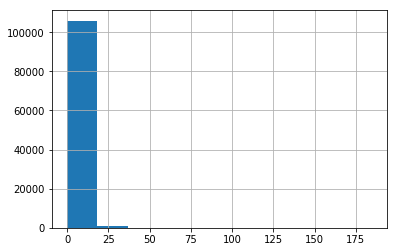

In [17]:

N_TARGETS = 20

df['target'] = np.log(1.+df['position'].copy())
df.loc[df['target'] > N_TARGETS, 'target'] = np.log(1.+N_TARGETS)
df['target'].fillna(NAN_FLAG, inplace=True)

#df['target'] = df['final_odds_ref'].fillna(df['final_odds_ref'].mean())

#df['target'] = df['winner_dividend'].fillna(0.)

#df['target'].fillna( NAN_FLAG, inplace=True )


#df['target'] = df['winner_dividend']/100.

#df['target'].fillna(NAN_FLAG, inplace=True)

df['target'] = df['winner_dividend'].fillna(0.)/100.

df['target'].hist()



In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df['race_id'].values

group_kfold = GroupKFold(n_splits=2)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

models = [
    {
        'name': 'knn_5',
        'model': KNeighborsRegressor(n_neighbors=5),
        'scaler': True
    },
    {
        'name': 'knn_10',
        'model': KNeighborsRegressor(n_neighbors=10),
        'scaler': True
    },
    {
        'name': 'knn_30',
        'model': KNeighborsRegressor(n_neighbors=30),
        'scaler': True
    },
    {
        'name': 'knn_90',
        'model': KNeighborsRegressor(n_neighbors=150),
        'scaler': True
    },
    {
        'name': 'rf_10',
        'model': RandomForestRegressor(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestRegressor(n_estimators=100),
        'scaler': False
    },
]

for model in models:
    for i in range(N_TARGETS):
        df['pred_{}_{}'.format(model['name'], i+1)] = 0.0
        df_test['pred_{}_{}'.format(model['name'], i+1)] = 0.0


In [19]:

for train_index, test_index in splits:
    
    for model in models:

        X_train = df[features].iloc[train_index].copy()
        y_train = df['target'].iloc[train_index]

        dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
        X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)

        X_train = X_train[ (df.iloc[train_index]['target'] != NAN_FLAG) & (df.iloc[train_index]['final_odds_ref'] < 20) ]
        y_train = df['target'].iloc[train_index][ (df.iloc[train_index]['target'] != NAN_FLAG) & (df.iloc[train_index]['final_odds_ref'] < 20) ]

        X_test = df[features].iloc[test_index].copy()
        y_test = df['target'].iloc[test_index]
    
        X_val = df_test[features].copy()

        X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
        X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

        X_train = X_train.values
        X_test = X_test.values
        X_val = X_val.values

        idx = df.iloc[test_index].index

        if model['scaler']:
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            #X_val = scaler.transform(X_val)

        clf = model['model']
        clf.fit(X_train, y_train.values)

        '''
        p = clf.predict_proba(X_test)
    
        print( model['name'], log_loss(y_test.values, p) )

        for i in range(N_TARGETS):
            df.loc[idx, 'pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

        p = clf.predict_proba(X_val)
    
        for i in range(N_TARGETS):
            df_test['pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]
        '''
        
        p = clf.predict(X_test)
        
        df.loc[idx, 'pred_{}_1'.format(model['name'])] = p
        
        print( model['name'], mean_absolute_error(y_test.values, p) )
    
    
    
    

knn_5 1.4795148904289193
knn_10 1.4738527814197415
knn_30 1.4656112255728286
knn_90 1.466316051695074
rf_10 1.7373653199550652
rf_100 1.7448937364384798
knn_5 1.4386192170818504
knn_10 1.441857463944559
knn_30 1.444917649996878
knn_90 1.4399372416807141
rf_10 1.776990844590156
rf_100 1.777384390496419


In [20]:
races = df.groupby('race_id')

N_TARGETS = 1

agg_preds = []

for i in range(N_TARGETS):
    for model in models:
        for s in ['mean', 'std', 'r']:
            col = 'pred_{}_{}_{}'.format(model['name'], i+1, s)
            if col in df.columns:
                df.drop(col, axis=1, inplace=True)
        
for i in range(N_TARGETS):
    for model in models:
        col = 'pred_{}_{}'.format(model['name'], i+1)
        agg_preds.append(col)
        
stats = races[agg_preds].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='left', on='race_id')

for f in agg_preds:
    col = '{}_r'.format(f)
    df[col] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_preds = ['{}_r'.format(f) for f in agg_preds] + ['{}_std'.format(f) for f in agg_preds] + ['{}_mean'.format(f) for f in agg_preds]

df[agg_preds] = df[agg_preds].replace([np.inf, -np.inf], np.nan)
df[agg_preds] = df[agg_preds].fillna(NAN_FLAG)


In [21]:
random_race(df, ['final_odds', 'position', 'final_odds_ref', 'final_odds', 'target'] + ['pred_{}_1'.format(model['name']) for model in models] +  ['pred_{}_1_mean'.format(model['name']) for model in models])

final_odds  position  final_odds_ref  final_odds  target  \
race_id index                                                             
1737    12289        15.1       4.0            21.9        15.1     0.0   
        12290         2.3       2.0             2.2         2.3     0.0   
        12291         8.5       6.0            10.1         8.5     0.0   
        12292         5.0       3.0             4.8         5.0     0.0   
        12293         5.9       5.0             5.7         5.9     0.0   
        12294         5.2       1.0             5.0         5.2     0.0   

               pred_knn_5_1  pred_knn_10_1  pred_knn_30_1  pred_knn_90_1  \
race_id index                                                              
1737    12289          0.00           0.00       0.423333       0.495333   
        12290          0.00           0.00       0.563333       0.527333   
        12291          2.16           2.12       1.203333       0.758000   
        12292          0.38           0.19       0.423333       0.498667   
        12293          0.00           0.19       0.063333       0.356667   
        12294          0.00           0.00       0.680000       0.579333   

               pred_rf_10_1  pred_rf_100_1  pred_knn_5_1_mean  \
race_id index                                                   
1737    12289          2.77          1.349           0.423333   
        12290          0.90          0.931           0.423333   
        12291          3.83          3.497           0.423333   
        12292          0.29          0.664           0.423333   
        12293          0.00          0.862           0.423333   
        12294          0.00          0.882           0.423333   

               pred_knn_10_1_mean  pred_knn_30_1_mean  pred_knn_90_1_mean  \
race_id index                                                               
1737    12289            0.416667            0.559444            0.535889   
        12290            0.416667            0.559444            0.535889   
        12291            0.416667            0.559444            0.535889   
        12292            0.416667            0.559444            0.535889   
        12293            0.416667            0.559444            0.535889   
        12294            0.416667            0.559444            0.535889   

               pred_rf_10_1_mean  pred_rf_100_1_mean  
race_id index                                         
1737    12289           1.298333            1.364167  
        12290           1.298333            1.364167  
        12291           1.298333            1.364167  
        12292           1.298333            1.364167  
        12293           1.298333            1.364167  
        12294           1.298333            1.364167

In [22]:
features

['race_count_r',
 'victory_count_r',
 'placed_2_count_r',
 'placed_3_count_r',
 'victory_earnings_r',
 'prev_year_earnings_r',
 'handicap_distance_r',
 'handicap_weight_r',
 'hist_1_pos_r',
 'hist_2_pos_r',
 'hist_3_pos_r',
 'hist_4_pos_r',
 'hist_5_pos_r',
 'hist_6_pos_r',
 'race_count_std',
 'victory_count_std',
 'placed_2_count_std',
 'placed_3_count_std',
 'victory_earnings_std',
 'prev_year_earnings_std',
 'handicap_distance_std',
 'handicap_weight_std',
 'final_odds_ref_std',
 'hist_1_pos_std',
 'hist_2_pos_std',
 'hist_3_pos_std',
 'hist_4_pos_std',
 'hist_5_pos_std',
 'hist_6_pos_std',
 'race_count_mean',
 'victory_count_mean',
 'placed_2_count_mean',
 'placed_3_count_mean',
 'victory_earnings_mean',
 'prev_year_earnings_mean',
 'handicap_distance_mean',
 'handicap_weight_mean',
 'final_odds_ref_mean',
 'hist_1_pos_mean',
 'hist_2_pos_mean',
 'hist_3_pos_mean',
 'hist_4_pos_mean',
 'hist_5_pos_mean',
 'hist_6_pos_mean',
 'declared_player_count',
 'hist_1_pos',
 'hist_2_pos',
 '

In [23]:
stacked_features = ['final_odds_ref', 'declared_player_count', 'final_odds_ref_std'] + ['odds_{:d}'.format(i) for i in range(10)]
df['final_odds_ref'].fillna(NAN_FLAG, inplace=True)

for i in range(N_TARGETS):
    stacked_features = stacked_features + ['pred_{}_{}'.format(model['name'], i+1) for model in models]
    
stacked_features = stacked_features + agg_preds# + ['gp_feat_{}'.format(i+1) for i in range(N_GP_FEATURES)]

stacked_features =   stacked_features

stacked_features



['final_odds_ref',
 'declared_player_count',
 'final_odds_ref_std',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'pred_knn_5_1',
 'pred_knn_10_1',
 'pred_knn_30_1',
 'pred_knn_90_1',
 'pred_rf_10_1',
 'pred_rf_100_1',
 'pred_knn_5_1_r',
 'pred_knn_10_1_r',
 'pred_knn_30_1_r',
 'pred_knn_90_1_r',
 'pred_rf_10_1_r',
 'pred_rf_100_1_r',
 'pred_knn_5_1_std',
 'pred_knn_10_1_std',
 'pred_knn_30_1_std',
 'pred_knn_90_1_std',
 'pred_rf_10_1_std',
 'pred_rf_100_1_std',
 'pred_knn_5_1_mean',
 'pred_knn_10_1_mean',
 'pred_knn_30_1_mean',
 'pred_knn_90_1_mean',
 'pred_rf_10_1_mean',
 'pred_rf_100_1_mean']

In [25]:
from sklearn.linear_model import LogisticRegression
#from gplearn.genetic import SymbolicRegressor

N_TARGETS_STACKED = 20

df['target_stacked'] = df['position'].copy()

'''
df['target_stacked'] = df['target_stacked'] / df['declared_player_count']
df['target_stacked'].fillna(df['target_stacked'].mean(), inplace=True)
df['target_stacked'] = np.exp(1. + df['target_stacked'])
'''


#df['target_stacked'] = df['target_stacked'].apply(lambda r: 1 if r >= 1 and r <= 2 else r-1 if r > 2 else r  )

df.loc[df['target_stacked'] > N_TARGETS_STACKED, 'target_stacked'] = N_TARGETS_STACKED
df['target_stacked'].fillna(N_TARGETS_STACKED, inplace=True)

df['target_stacked'] = df['target_stacked'].apply(lambda v: -1000 if v == 1 else v)


df['pred_stacked'] = 0.0
for i in range(N_TARGETS_STACKED):
    df['pred_stacked_{}'.format(i+1)] = 0.0
    df_test['pred_stacked_{}'.format(i+1)] = 0.0

#df['target_stacked'] = np.ceil(1.+df['position'].fillna( 0. ))

df['target_stacked'] = df['winner_dividend'].fillna(0.)

#df['target_stacked'] = df['target'].copy()

df['target_stacked'].describe()

count    106780.000000
mean         77.619404
std         408.173569
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       18440.000000
Name: target_stacked, dtype: float64

In [28]:
df['target_stacked'].describe()

count    106780.000000
mean         77.619404
std         408.173569
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       18440.000000
Name: target_stacked, dtype: float64

In [29]:
from sklearn import linear_model

for train_index, test_index in splits:

    X_train = df[stacked_features].iloc[train_index].copy()
    y_train = df['target_stacked'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[(df.iloc[train_index]['target_stacked'] != NAN_FLAG) & (df.iloc[train_index]['sub_category'] != 'fHANDICAP') & (df.iloc[train_index]['final_odds_ref'] < 20) ]
    y_train = df['target_stacked'].iloc[train_index][(df.iloc[train_index]['target_stacked'] != NAN_FLAG) & (df.iloc[train_index]['sub_category'] != 'fHANDICAP') & (df.iloc[train_index]['final_odds_ref'] < 20) ]

    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target_stacked'].iloc[test_index]
    
    #X_val = df_test[stacked_features].copy()

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
    #X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    #X_val = X_val.values

    idx = df.iloc[test_index].index
    
    scaler = StandardScaler()
    scaler.fit(X_train)

    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #X_val = scaler.transform(X_val)
    
    '''
    clf = MLPClassifier(hidden_layer_sizes=(100), activation='tanh', batch_size=20)
    #clf = RandomForestClassifier(n_estimators=150)
    #clf = AdaBoostClassifier(n_estimators=250)
    #clf = SVC(probability=True)
    #clf = KNeighborsClassifier(n_neighbors=25)

    clf.fit(X_train, y_train.values)
    
    p = clf.predict_proba(X_test)
    
    print( log_loss(y_test.values, p) )

    df.loc[idx, 'pred_stacked'] = p[:, list(clf.classes_).index(1)]
    for i in range(N_TARGETS_STACKED):
        df.loc[idx, 'pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    #p = clf.predict_proba(X_val)
    
    #for i in range(N_TARGETS_STACKED):
    #    df_test['pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]
    
    '''
       
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
    
    #reg = linear_model.Ridge()
    #reg = SVR()
    reg = MLPRegressor(hidden_layer_sizes=(10), activation='tanh', batch_size=20)
    #reg = RandomForestRegressor(n_estimators=100)
    #reg = KNeighborsRegressor(n_neighbors=3, weights='distance')
    '''
    function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv', 'cos', 'sin',
                'max', 'min']
    from gplearn.fitness import make_fitness
    
    def _metric(y, y_pred, w):
        
        diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),
                             np.maximum(0.001, y)))
        return 100. * np.average(diffs, weights=w)        
    
    metric = make_fitness(_metric, greater_is_better=False)
    
    reg = SymbolicRegressor(function_set=function_set, 
                            verbose=True,
                            const_range=(-100, 100),
                            parsimony_coefficient=0.00001,
                            max_samples=0.8, metric=metric)
                        '''
    reg.fit(X_train, y_train.values)
    
    p = reg.predict(X_test)
    df.loc[idx, 'pred_stacked_1'] = p
    
    print( mean_absolute_error(y_test.values, p) )





/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


133.2250237598047
130.07136524609584


In [30]:
random_race(df, cols=['position', 'final_odds_ref', 'winner_dividend', 'sub_category', 'target_stacked', 'pred_stacked_1', 'pred_stacked_2', 'pred_stacked_3']).sort_values('pred_stacked_1')

position  final_odds_ref  winner_dividend sub_category  \
race_id index                                                           
11256   77323       8.0            49.0              0.0    AUTOSTART   
        77324       5.0            44.7              0.0    AUTOSTART   
        77326       NaN            32.7              0.0    AUTOSTART   
        77316       6.0            33.4              0.0    AUTOSTART   
        77314       NaN            26.0              0.0    AUTOSTART   
        77322       7.0            19.9              0.0    AUTOSTART   
        77315       4.0            21.9              0.0    AUTOSTART   
        77318       2.0            10.5              0.0    AUTOSTART   
        77317       3.0            23.5              0.0    AUTOSTART   
        77325       9.0            15.0              0.0    AUTOSTART   
        77319       NaN             2.3              0.0    AUTOSTART   
        77320       1.0             3.0            250.0    AUTOSTART   

               target_stacked  pred_stacked_1  pred_stacked_2  pred_stacked_3  
race_id index                                                                  
11256   77323             0.0      -23.867666             0.0             0.0  
        77324             0.0      -12.576380             0.0             0.0  
        77326             0.0        5.050323             0.0             0.0  
        77316             0.0       13.446976             0.0             0.0  
        77314             0.0       26.163898             0.0             0.0  
        77322             0.0       35.392374             0.0             0.0  
        77315             0.0       47.878858             0.0             0.0  
        77318             0.0       57.211333             0.0             0.0  
        77317             0.0       57.408507             0.0             0.0  
        77325             0.0       58.680752             0.0             0.0  
        77319             0.0       65.100155             0.0             0.0  
        77320           250.0       95.691289             0.0             0.0

In [31]:
fi = pd.Series(reg.feature_importances_, index=stacked_features)
print(fi.sort_values(ascending=False))

AttributeError: 'MLPRegressor' object has no attribute 'feature_importances_'

In [44]:
#df_test['rnd'] = np.random.rand(len(df_tes))

#df['strat_1'] = df['pred_knn_150_1'] + df['pred_knn_30_1'] + df['pred_knn_10_1'] + df['pred_knn_5_1']
df['strat_1'] = df['pred_stacked_1']#df['pred_knn_5_1'] + df['pred_knn_10_1'] + df['pred_knn_30_1'] + df['pred_knn_150_1']

races = df.sort_values('start_at').groupby('race_id')

strats = ['strat_1']

bets = []

stash = 500

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(strats, 1):
        
#        if len(nums) > 0:
#            break

        r = race.sort_values(by=target, ascending=False)
    
        #r = r[r['final_odds_ref']<40.]
        
        odds = r['final_odds_ref'].min()
        nth = len(r[r['final_odds_ref']<odds])+1
    
        N = 10


        for n in range(N):
            
            if len(r) <= N:
                continue

            player = r.iloc[n]

            if player['sub_category'] != 'COURSE_A_CONDITIONS':
                pass

            if player['num'] in nums:
                continue
                
            if player['pred_stacked_1'] <= 0:
                continue

            odds = player['final_odds_ref']
            nth = (r['final_odds_ref']<odds).sum()+1

            if np.isnan(odds) or odds > 20 or odds < 1:
                continue
                
            #if nth > 4:
            #    continue
                
            if race['final_odds_ref'].min() < 1:
                continue
                
            if race['final_odds_ref'].max() > 20:
                pass

            
            bet = min( 9., 1.5*np.floor(max(stash*0.01, 0.)) )
            
            bet = 1./player['declared_player_count']
            
            bet = np.floor(1+1/np.log(odds))
            
            bet = 1.# / player['final_odds_ref']
        
            profit = player['winner_dividend']/100.0 * bet - bet
            
            stash = stash + profit

            #print(player['sub_category'], player['country'], player['declared_player_count'], player['final_odds_ref'], race['final_odds_ref'].describe())

            bets.append( (id, race['race_count'].min(), player['sub_category'], player['country'], player[target], nth, player['declared_player_count'], player['start_at'], bet, player['position'], player['final_odds'], player['pred_stacked_1'], race['final_odds_ref'].std(), player['num'], profit) )

            nums.append(player['num'])
            
            if len(nums) >= 1:
                break



bets = pd.DataFrame(bets, columns=['id', 'race_count_min', 'cat', 'country', 'target', 'nth', 'n', 'date', 'bet', 'pos', 'odds', 'pred_1', 'num', 'odds_std', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['bets'] = bets['bet'].cumsum()
bets['stash'] = bets['profit'].cumsum()


In [45]:
bets_orig = bets.copy()

In [46]:
bets = bets_orig

In [47]:
from cataclop.ml.exploration import loss_streak

bets = bets[(bets['profit']>0) | (bets['pos'] != 1)]
#bets = bets[bets['cat'] == 'HANDICAP']

print('from:', bets['date'].min(), 'to:', bets['date'].max())

print('loss streak:', loss_streak(bets))
print('bets:', (bets['bet']>0).sum())
print('bets:', bets['bet'].sum(), '€')
print('profits:', bets['profit'].sum(), '€')
print('returns:', 100. * (bets['profit'].sum() / bets['bet'].sum()), '%')
print('win rate:', 100. * (bets['profit']>0).astype('float').mean(), '%')

from: 2017-01-01 14:27:00 to: 2018-06-05 21:24:00
loss streak: 49
bets: 5185
bets: 5185.0 €
profits: -858.2 €
returns: -16.551591128254582 %
win rate: 15.988428158148505 %


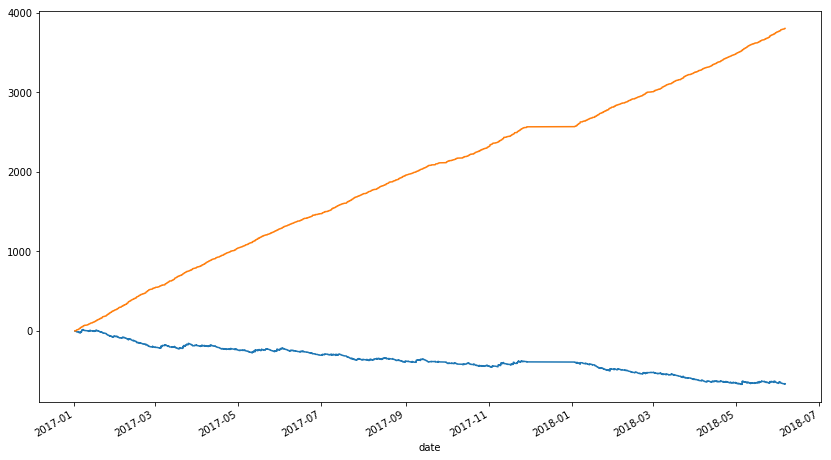

In [42]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

bb = bets.copy()#bets[(bets['nth']>1.) & (bets['cat']=='HANDICAP') & (bets['odds']>10)].copy()
bb = bets[(bets['nth']>0.) & (bets['n']>0) & (bets['odds']>0)].copy()

bb['stash'] = bb['profit'].cumsum()
bb['bets'] = bb['bet'].cumsum()

bb['stash'].plot()
bb['bets'].plot(figsize=(14,8))

cat     AMATEURS_AUTOSTART  AMATEURS_EUROPEENNE_AUTOSTART  \
profit           -0.023636                           -1.0   
profit           55.000000                            1.0   

cat     AMATEURS_INTERNATIONALE_AUTOSTART  APPRENTIS_LADS_JOCKEYS_AUTOSTART  \
profit                               -1.0                          0.125862   
profit                                4.0                         58.000000   

cat     APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART   AUTOSTART  A_RECLAMER  \
profit                                     0.618182   -0.135875   -0.168561   
profit                                    11.000000  577.000000  264.000000   

cat     A_RECLAMER_AUTOSTART  COURSE_A_CONDITIONS  \
profit             -0.778571            -0.212879   
profit             14.000000           528.000000   

cat     COURSE_A_CONDITION_QUALIF_HP  EUROPEENNE_AUTOSTART   GROUPE_I  \
profit                      0.583871             -0.395238  -0.587879   
profit                     31.0000

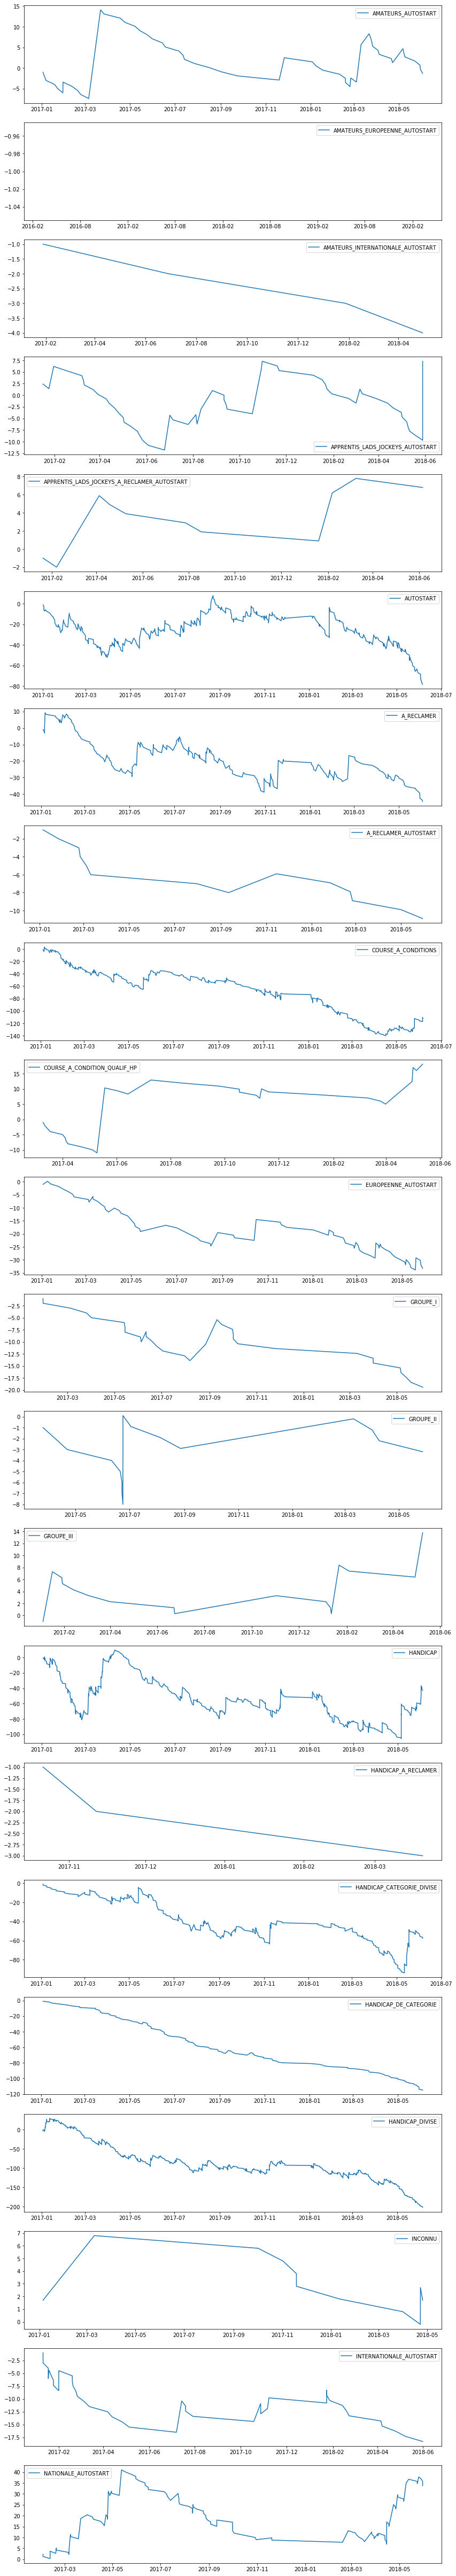

In [48]:
x = bb.index

bets_cat = bb.groupby('cat')

fig, axs = plt.subplots(len(bets_cat), 1, figsize=(14,4*len(bets_cat)))

print( pd.DataFrame([bets_cat['profit'].mean(), bets_cat['profit'].count()]) )

i = 0
for cat, b in bets_cat:
    d = b['profit'].cumsum()
    x = d.index
    y = d.values
    axs[i].plot(x, y, label=cat);
    axs[i].legend();
    #(b['profit'].cumsum()).plot(label=cat, subplots=True, ax=axs[i])
    i = i + 1
    


In [ ]:
b.index


In [ ]:
bets[['id', 'cat', 'pos', 'odds', 'pred_1', 'profit', 'bet']][bets['cat']=='APPRENTIS_LADS_JOCKEYS_AUTOSTART']

In [ ]:
bets['nth_r'] = bets['nth'] / bets['n']
bets[bets['profit']>0].describe()

In [ ]:
bets[bets['profit']<0].describe()

In [ ]:
bets[bets['odds']>15]['profit'].describe()

In [ ]:
bets.plot.scatter(x='profit', y='pred_1', figsize=(14,8))

In [ ]:
bets['pred_1'].hist(bins=20)

In [ ]:
df[df['race_id']==4919][['position', 'winner_dividend']]